# **Part 3: Deep Learning for Time Series**


## Instructors: 

* Rockefeller
* Dr Yae Gaba
* Dr Colleen Farrelly
    
    
Time Series Applications, AMLD Africa, Morocco 2022. 

# **Sequential Data Modeling with Recurrent Neural Networks**


**Recurrent Neural Networks** can be used for many tasks that involved sequential date. This inclues speech recognition, voice recognition, time series prediction, and natural language processing

In [8]:
import torch
import torch.nn as nn
import math
from scipy.integrate import odeint
import random
from IPython import display
from torch.autograd import Variable
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from torch.nn.parameter import Parameter
from IPython.display import Image
from matplotlib import colors as mcolors
from IPython import display
#dtype = torch.cuda.FloatTensor

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
dtype= torch.cuda.FloatTensor



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd "/content/drive/MyDrive/AMLD_files"

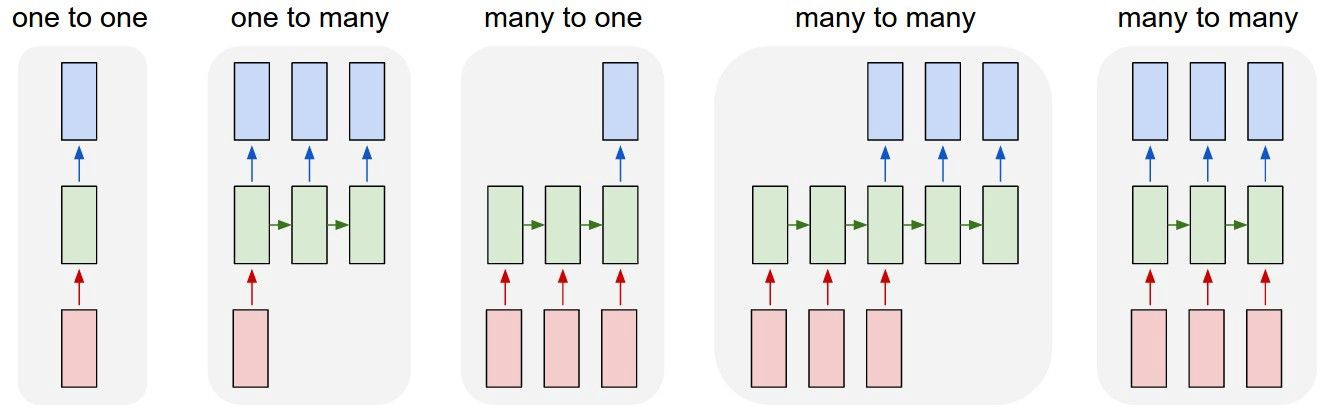

In [5]:
Image('images/differents_RNNs.jpeg')

In [150]:
Since w

Google Colab provides you with free GPU access to run deep learning code incredibly faster. Even though we have enabled the use of it, it is safe to check if its available or not, which is done through the line below. 
If you get **cpu** as an output, this means that you are not connected to the GPU. 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


In [ ]:
torch.cuda.is_available()

The line above also helps us define  a **device** variable to which all the arrays/tensors we will manipulating throughout this tutorial will be plugged into.

# Create dataset

In [18]:
y = []
for i in range(360):
  y.append(np.sin(i*np.pi/10) + random.random())

$$y(x) = sin(x) + \epsilon$$

In [ ]:
X = np.arange(0, 360)
df = pd.DataFrame({"time_point": X, "sin_value":y})
df.head(10)

It's always important to see what you are doing. You can save a lot of time like this ;)

In [ ]:
plt.figure(figsize=(25,4))
plt.plot(df.sin_value)
plt.xlabel('time_steps')
plt.ylabel('values')
plt.show()

For this forecast exercise, we will try and forecast the last 50 time points of our sin wave , provided above

In [ ]:
plt.figure(figsize=(25,4))
plt.plot(df.sin_value)
plt.axvline(x=300, color='r', linestyle='-')
plt.xlabel('time_steps')
plt.ylabel('values')
plt.show()

## Training and Testing datasets 
Lets separate our data into training and testing sets

In [23]:
reshaped_data =  df.sin_value.values.reshape(len(df), 1)

In [24]:
forecast_horizon = 50
training_data =  reshaped_data[:-forecast_horizon]
test_data = reshaped_data[-forecast_horizon:]

print(training_data.shape , test_data.shape)

(310, 1) (50, 1)


In [ ]:
sinValues = pd.DataFrame(df.sin_value.values[:-forecast_horizon])

df_new = pd.concat([sinValues.shift(1), sinValues], axis=1)
df_new.columns = [ 't-1', 't']
df_new = df_new.dropna(how= 'any')
df_new.head(10)

In [167]:
# Change the code so that it can increase the rolling window size?
# sinValues = pd.DataFrame(df.sin_value.values[:-forecast_horizon])

# df_new = pd.concat([sinValues.shift(2), sinValues.shift(1), sinValues], axis=1)
# df_new.columns = ['t-2' , 't-1', 't']
# df_new = df_new.dropna(how= 'any')
# df_new.head(5)

The SimpleRNN model expects a 3D (`[samples, time steps, features]`) dataset so we reshape them accordingly 

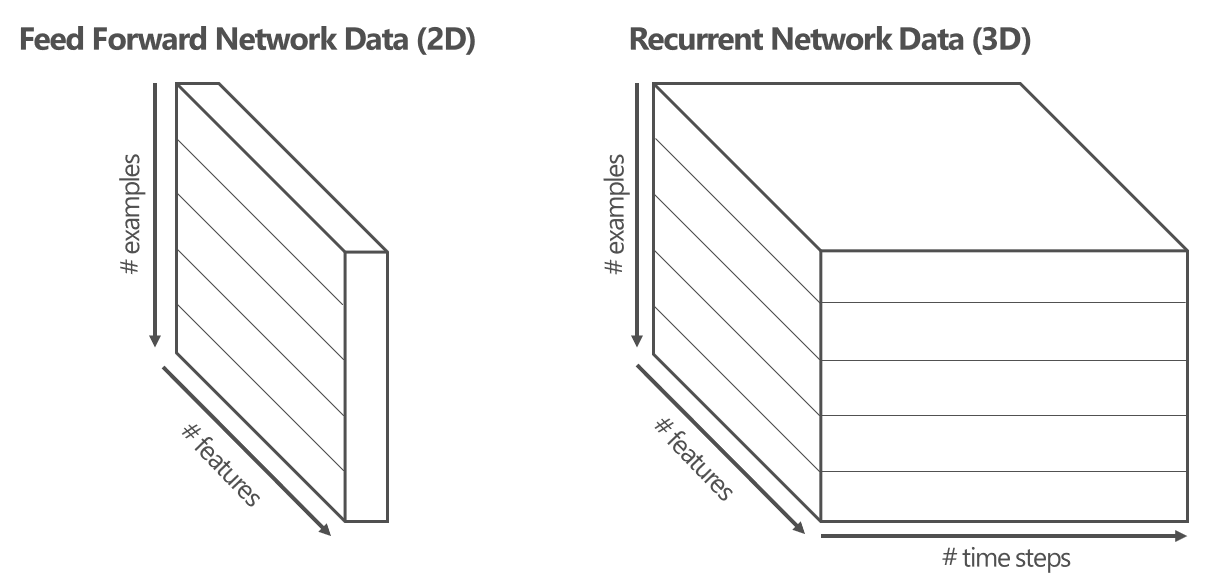

In [28]:
Image('images/rnn_data_prep.png', width=800)

the function below just does the data. It takes as input the raw data and the width of the window and return it organized into training and test sets with the adequate pattern `(samples, time steps, features)`

In [29]:
def sliding_windows(data, window_size):
    x = []
    y = []
    L = len(data)
    
    for i in range(L-window_size):
        window_ = data[i:i+window_size]
        label = data[i+window_size:i+window_size+1]
        x.append(window_)
        y.append(label)
    
    return np.array(x),np.array(y)

In [ ]:
tr_data =  np.arange(12)
tr_data

In [39]:
tr_data =  tr_data.reshape(12,1)
window_size =   10
x, y = sliding_windows(tr_data, window_size)


In [ ]:
x.shape

* The number of samples is **2**
* The number of time steps is **10**
* The number of features is **1**

In [ ]:
print(x)

In [ ]:
print(y)

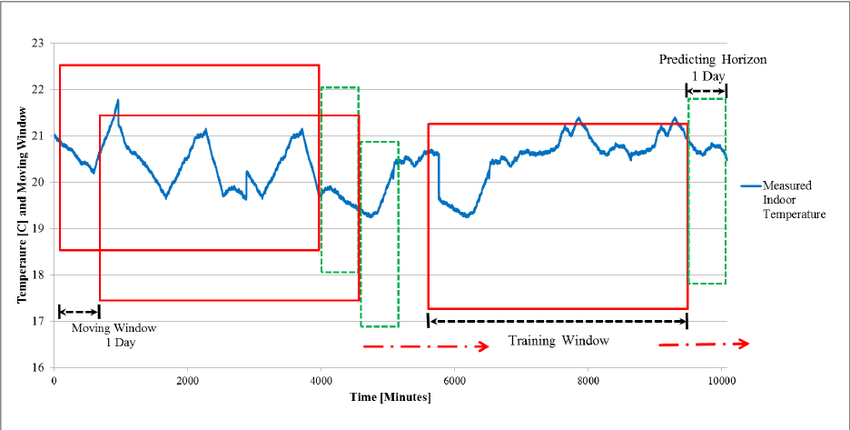

In [37]:
Image('images/rolling_window.png' , width=1000)

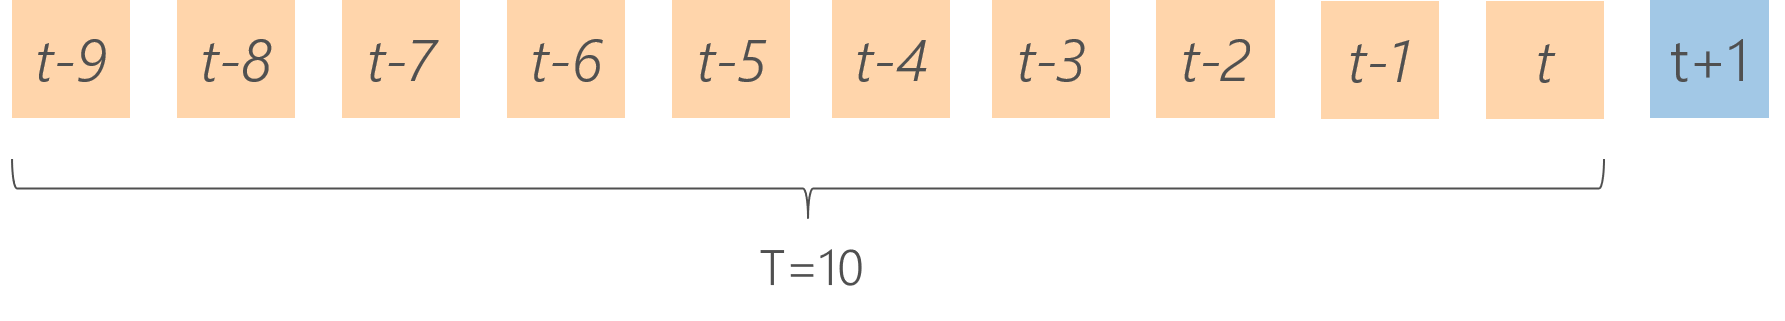

In [38]:
Image('images/many_to_one_forecast.png')

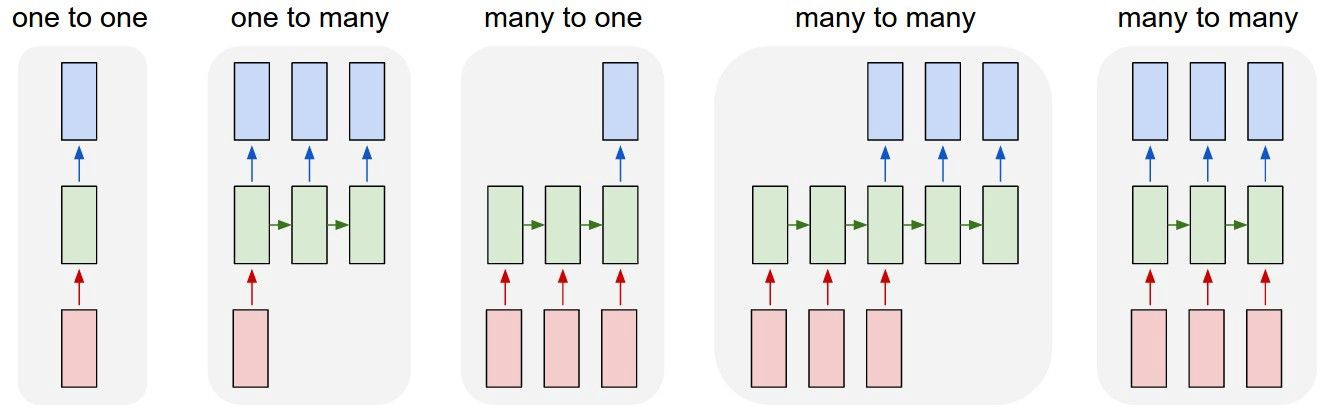

In [90]:
Image('images/differents_RNNs.jpeg')

Let's return to our sin wave example

In [42]:
window_size = 10
train_x, train_y = sliding_windows(training_data, window_size)

In [ ]:
print(train_x.shape   , train_y.shape)

In [46]:
#dtype= torch.cuda.FloatTensor
tens_trainX = Variable(torch.Tensor(np.array(train_x))).to(device)
tens_trainY = Variable(torch.Tensor(np.array(train_y))).to(device)

In [ ]:
print ( tens_trainX.shape , type(tens_trainX))

In [ ]:
print ( tens_trainY.shape , type(tens_trainY))

Notice that our RNN will learn to use a sliding window of 10 steps to forecast only one timestep

## Define the model architecture. 
We'll be using a SimpleRNN model to start. Let's see how you could build such from scratch. 

Neural networks comprise of layers/modules that perform operations on data. The torch.nn namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the nn.Module. A neural network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

In [49]:
from IPython.core.display import display, HTML


Check this  [link](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) for more RNN Layer

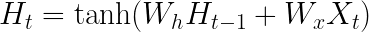

In [50]:
Image('images/tr_eqRNN.png')

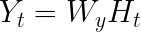

In [51]:
Image('images/out_eqRNN.png')

In [52]:
class VanillaRNN(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(VanillaRNN, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, bias =  False, batch_first=False)#.type(dtype)
        
        self.fc = nn.Linear(hidden_size, num_classes , bias =  False)#.type(dtype)


    def forward(self, x):
      all_h_states , last_h_state = self.rnn(x)
      y_hat = self.fc(last_h_state)
      return y_hat

## Instantiate the model

In [ ]:
train_x.shape

In [ ]:
input_size = train_x.shape[2]   #the number of features
hidden_size =  20  #the number of hidden states neurons
num_classes = train_x.shape[2]  
num_layers = 1 # shallow RNN
rnn_model = VanillaRNN(num_classes, input_size, hidden_size, num_layers)
rnn_model.to(device)

In [ ]:
print(list(rnn_model.parameters()))

In [ ]:
for param in list(rnn_model.parameters()):
  print(param.shape)

In [65]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
learning_rate= 0.001
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)
epochs =100

In [ ]:
losses = []

for epoch in range(epochs):
    outputs = torch.empty(tens_trainY[:-1].shape).type(dtype)
    optimizer.zero_grad()
    for batch_ , data in enumerate(tens_trainX[:-1]): 
            
        outputs[batch_] = rnn_model(data)
      
    
    # obtain the loss function
    loss = criterion(outputs,tens_trainY[:-1])
    losses.append(loss.item())
    print("epoch {0}/{1} ========= tr_loss = {2} ".format(epoch, epochs  , round(loss.item() , 4)))
    loss.backward()

    optimizer.step()

pred_  = rnn_model(tens_trainX[-1] )
val_loss = criterion(pred_ ,tens_trainY[-1] )
print("test_loss = " , round(val_loss.item() , 4))

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.show()

## Make predictions

In [83]:
def train( model , tens_train_x , tens_train_y , test_data , learning_rate , epochs ):
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  #or you could replace SGD
    results = dict()
    t_shold = 10000
    losses =[]

    for epoch in range(epochs):
        outputs = torch.empty(tens_train_y[:-1].shape).to(device)
        optimizer.zero_grad()
        for batch_ , data in enumerate(tens_train_x[:-1]): 
            
            
            outputs[batch_] = model(data)
          
        loss = criterion(outputs,tens_trainY[:-1])
        print("epoch {0}/{1} ========= tr_loss = {2} ".format(epoch+1, epochs  , round(loss.item() , 4)))
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        preds = training_data[-window_size:].tolist()
        for step_ in range(forecast_horizon):
            seq = torch.FloatTensor(preds[-window_size:]).to(device)
            with torch.no_grad():
                y_pred = model(seq)
                preds.append(y_pred[-1].tolist())

        f_cast =  torch.FloatTensor(preds)[-forecast_horizon:]
        v_loss = criterion(f_cast , torch.tensor(test_data)).item()
        results['losses']  = losses
        print("val_loss", round(v_loss , 5))
        if v_loss < t_shold:
        
          results['pred'] = f_cast
          results['train_pred'] = outputs
          results['epoch'] = epoch+1
          t_shold =  v_loss

    return results

In [84]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
learning_rate= 0.001
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)
epochs =100

In [ ]:
results =  train(rnn_model , tens_trainX , tens_trainY , test_data , learning_rate , epochs)

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(results['losses'])
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.show()

In [87]:
#remove from the GPU and casting to Numpy object
pred_train = results['train_pred'].squeeze(1).detach().cpu().numpy()
true_train = tens_trainY[:,0,0].detach().cpu().numpy()
pred_test = results['pred'].squeeze(1).detach().cpu().numpy()
true_test = test_data[:,0]


In [ ]:
plt.figure(figsize=(25,4))
plt.plot(pred_train[1:] , label ='pred_train')
plt.plot(true_train , label ='true_train')
plt.title("simple RNN on train data ")
plt.legend(loc='best')
plt.plot()

In [ ]:
plt.figure(figsize=(25,4))
plt.plot(pred_test , label ='y_pred')
plt.plot(true_test , label ='y_true')
plt.title("simple RNN on test_data ")
plt.legend(loc='upper right')

Lets try the same with LSTM

# LSTM
Let's now try using a slightly more sophisticated architecture

In [90]:
dtype= torch.FloatTensor
class LSTM_Model(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM_Model, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, bias =  False, batch_first=False)
        
        self.fcast = nn.Linear(hidden_size, num_classes , bias =  False)

    def forward(self, x):
#         h_0 = Variable(torch.zeros(
#             self.num_layers, x.size(0), self.hidden_size))
        
#         c_0 = Variable(torch.zeros(
#             self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        out , (h_out, _) = self.lstm(x)
        #h_out = h_out.view(-1, self.hidden_size) #introducing new axis 1row, ncols 
        
        out = self.fcast(h_out)
        
        return out

In [91]:
input_size = train_x.shape[2]   #the number of features
hidden_size =  100  #the number of hidden states neurons
num_classes = train_y.shape[2]  
num_layers = 1 # shallow RNN
lstm_model = LSTM_Model(num_classes, input_size, hidden_size, num_layers)
lstm_model.to(device)

LSTM_Model(
  (lstm): LSTM(1, 50, bias=False)
  (fcast): Linear(in_features=50, out_features=1, bias=False)
)

In [ ]:
print(list(lstm_model.parameters()))

In [92]:
for param in list(lstm_model.parameters()):
  print(param.shape)

torch.Size([200, 1])
torch.Size([200, 50])
torch.Size([1, 50])


Calculate the predicted values

In [93]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
learning_rate= 0.01
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
epochs =100

In [ ]:
results =  train(lstm_model , tens_trainX , tens_trainY , test_data , learning_rate , epochs)

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(results['losses'])
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.show()

In [96]:
y_pred = results['pred'].squeeze(1).detach().cpu().numpy()
y_true = test_data[:,0]

In [99]:
#remove from the GPU and casting to Numpy object

pred_train = results['train_pred'].squeeze(1).detach().cpu().numpy()
true_train = tens_trainY[:,0,0].detach().cpu().numpy()
pred_test = results['pred'].squeeze(1).detach().cpu().numpy()
true_test = test_data[:,0]


In [ ]:
plt.figure(figsize=(20,4))
plt.plot(pred_train[1:] , label ='pred_train')
plt.plot(true_train , label ='true_train')
plt.title("simple LSTM on train data ")
plt.legend(loc='best')
plt.plot()

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(pred_test , label ='y_pred')
plt.plot(true_test , label ='y_true')
plt.title("simple LSTM on test_data ")
plt.legend(loc='upper right')

# Multiple timesteps
So far we've been using architectures with just a single timestep. Now we'll see how we can use multiple timesteps (t-1, t) to predict the value at t+1. We'll keep the basic architecture of the system. We still have the raw data in memory, so we don't need to reload it. We just have to be careful when we build the inputs

The more we increas the lag, the more points we lose! The rest of the code looks pretty much the same

But now we see that the result is slightly different. For each of our examples, we now have 3 timesteps to consider. Now we just need to refine the model:

# Exercice:



1.   Load the dataset provided on the url adress below and design your own RNN and LSTM model.
2.   Train a Vanilla RNN model, report the characteristics of your model,  the error during training and provide a picture of your forecast.
3.   Train a LSTM model, report the characteristics of your model,  the error made during training and forecasting.

4. Provide a picture of the  forecast for both models.


5. Increase your past information and re-do step 2 and 3.


6. (Bonus) Apply a Preprocessing method of the climate product that you choose and re-do step 2 ,  3 and 4.


7. What did you learn from these experiments?




In [ ]:
#url = 'https://raw.githubusercontent.com/rock-feller/Datasets_for_Education/main/data_02/limbe_data_JanApr21.csv'

url = 'https://raw.githubusercontent.com/rock-feller/Datasets_for_Education/main/data_02/data_2020.csv'

In [102]:
import pandas as pd
url = 'https://raw.githubusercontent.com/rock-feller/Datasets_for_Education/main/data_02/data_2020.csv'

In [ ]:
df4 = pd.read_csv(url)#, parse_dates={'date':['YEAR', 'MO' , 'DY']})
df4.head(5)

In [ ]:
df4.tail(5)


In [ ]:
df4.columns

In [ ]:
df_new = df4[['date_time', 'WS_20_mean' , 'Tair_mean']]
df_new

In [ ]:
df_JanJun  = df_new.iloc[:4368, :]
df_JanJun

In [ ]:
for col in df_JanJun.columns[1:]:
    plt.figure(figsize=(25,4))
    plt.plot( df_JanJun[col], color=colors[np.random.randint(1,100,1)[0]])
    plt.title(col)

In [109]:
def ScaleAroundZero(data , p):
    data_avg = data.mean()
    scaled_data = p*(data - data_avg)# data.std()
    return scaled_data

In [110]:
df_rescaled  =pd.DataFrame()
for col in df_JanJun.columns[1:]:
  df_rescaled[col]=ScaleAroundZero(df_JanJun[col] , 0.05 )
#reshaped_data

In [ ]:
for col in df_new.columns[1:]:
    plt.figure(figsize=(25,4))
    plt.plot( df_rescaled[col], color=colors[np.random.randint(1,100,1)[0]])
    plt.title(col)

In [ ]:
forecast_horizon = 24
training_data =  df_rescaled.values[:-forecast_horizon]
test_data = df_rescaled.values[-forecast_horizon:]

print(training_data.shape , test_data.shape)

In [113]:
window_size = 240
train_x, train_y = sliding_windows(training_data, window_size)
dtype= torch.cuda.FloatTensor
tens_trainX = Variable(torch.Tensor(np.array(train_x))).to(device)
tens_trainY = Variable(torch.Tensor(np.array(train_y))).to(device)


In [ ]:
print(tens_trainX.shape)

In [ ]:
input_size = train_x.shape[2]   #the number of features
hidden_size =  100  #the number of hidden states neurons
num_classes = train_y.shape[2]  
num_layers = 1 # shallow RNN
rnn_model = VanillaRNN(num_classes, input_size, hidden_size, num_layers)
rnn_model.to(device)


In [116]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
learning_rate= 0.001
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)
epochs =100

In [ ]:
results =  train(rnn_model ,tens_trainX ,  tens_trainY  , test_data , learning_rate , epochs)

In [118]:
#remove from the GPU and casting to Numpy object
pred_train = results['train_pred'].squeeze(1).detach().cpu().numpy()
true_train = tens_trainY[:,0,0].detach().cpu().numpy()
pred_test = results['pred'].squeeze(1).detach().cpu().numpy()
true_test = test_data[:,0]



In [119]:
pred_train = results['train_pred'][:,0,:].detach().cpu().numpy()
true_train = tens_trainY[:,0,:].detach().cpu().numpy()
pred_test = results['pred'].detach().cpu().numpy()
true_test = test_data

In [ ]:
cols =  list(df_new.columns[1:])

for i in range(2):
  plt.figure(figsize=(25,4))
  plt.plot(pred_train[:,i] , label ='pred_train')
  plt.plot(true_train[:,i] , label ='true_train')
  plt.title("simple RNN on train data on " + cols[i] )
  plt.legend(loc='best')
  plt.show()

In [ ]:
cols =  list(df_new.columns[1:])

for i in range(2):
  plt.figure(figsize=(25,4))
  plt.plot(pred_test[:,i] , label ='pred_test')
  plt.plot(true_test[:,i] , label ='true_test')
  plt.title("simple RNN on train data on " + cols[i] )
  plt.legend(loc='best')
  plt.show()

In [ ]:
input_size = train_x.shape[2]   #the number of features
hidden_size =  100  #the number of hidden states neurons
num_classes = train_y.shape[2]  
num_layers = 1 # shallow RNN
lstm_model = LSTM_Model(num_classes, input_size, hidden_size, num_layers)
lstm_model.to(device)

In [128]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
learning_rate= 0.001
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
epochs =100


In [ ]:
results =  train(lstm_model ,tens_trainX ,  tens_trainY  , test_data , learning_rate , epochs)

In [130]:
#remove from the GPU and casting to Numpy object
pred_train = results['train_pred'].squeeze(1).detach().cpu().numpy()
true_train = tens_trainY[:,0,0].detach().cpu().numpy()
pred_test = results['pred'].squeeze(1).detach().cpu().numpy()
true_test = test_data[:,0]



In [131]:

pred_train = results['train_pred'][:,0,:].detach().cpu().numpy()
true_train = tens_trainY[:,0,:].detach().cpu().numpy()
pred_test = results['pred'].detach().cpu().numpy()
true_test = test_data



In [ ]:
cols =  list(df_new.columns[1:])

for i in range(2):
  plt.figure(figsize=(25,4))
  plt.plot(pred_train[:,i] , label ='pred_train')
  plt.plot(true_train[:,i] , label ='true_train')
  plt.title("simple RNN on train data on " + cols[i] )
  plt.legend(loc='best')
  plt.show()

In [ ]:
cols =  list(df_new.columns[1:])

for i in range(2):
  plt.figure(figsize=(25,4))
  plt.plot(pred_test[:,i] , label ='pred_test')
  plt.plot(true_test[:,i] , label ='true_test')
  plt.title("simple RNN on train data on " + cols[i] )
  plt.legend(loc='best')
  plt.show()

What do you think could be done to improve the forecast?

**References:**

1. Omar, Farhad, and Steven T. Bushby. A Self-learning Algorithm for Temperature Prediciton in a Single Family Residence. US Department of Commerce, National Institute of Standards and Technology, 2015.